# Telco Customers Churning Analysis

## Goal :

* Find out what are the drivers that are leading to customers churning
* Use the drivers to develop a machine learning model to see if features chosen result in churning

In [1]:
# Standard imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Prepping data imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Evaulation imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Stats imports
from scipy import stats

# My own imports
import acquire as a
import prepare
import explore as e
import model as m

# Time import
import time

# Itertools imports
import itertools
import operator

## Acquire

* Data was acquired from MySql database using telco_churn
* The datframe had 7043 rows and 24 columns before it was cleaned
* Rows represent telco customers 
* Columns are features that describe the customer

In [2]:
# using my acquire.py file

df = a.get_telco_data()

this file exists, reading csv


## Prepare

* Drops unnecessary columns
* Replace empty space values with 0.0 so it can have a value,
* Filled in null values in internet_service_type
* Split into train, validate, and test dataframes

In [3]:
# using my prepare.py file to clean the data with the transformations mentioned above
df = prepare.prep_telco(df)

In [4]:
# using my prepare.py file to split the data into train, validate, and test dataframes with churn as the stratifying column
train, validate, test = prepare.splitting_data(df, 'churn')

In [5]:
# Taking a quick look at the df
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,
4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,No,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,No,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,None,Mailed check
1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,No,No,Yes,No,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,No,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


In [6]:
# Checking the shapes of the new df's
train.shape, validate.shape, test.shape

((4225, 20), (1409, 20), (1409, 20))

## Explore

I asked the following questions during the explore phase

Q1: Does being a senior citizen affect churn?

Q2: Does being a female affect churn?
    
Q3: Does monthly charges affect churn?
    
Q4: Does having dependents affect churn?

Getting the answers to these questions can help us find what is contributing to customer churn.

Lets see how many customers are churning

In [7]:
train.churn.value_counts(normalize=True)

churn
No     0.734675
Yes    0.265325
Name: proportion, dtype: float64

> We can see that 27% of customers have churned

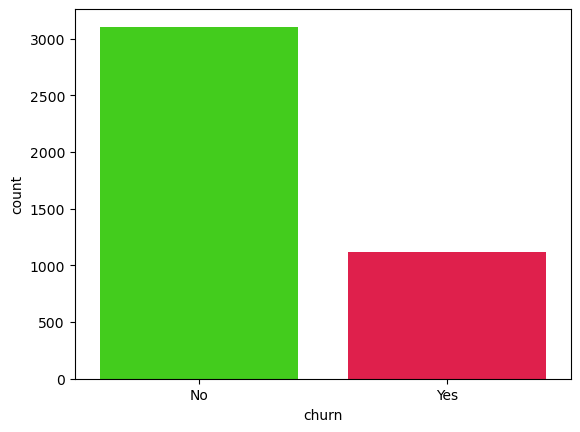

In [8]:
e.countplot_churn(train)

### Question 1 : Does being a senior citizen affect whether or not a customer churns?

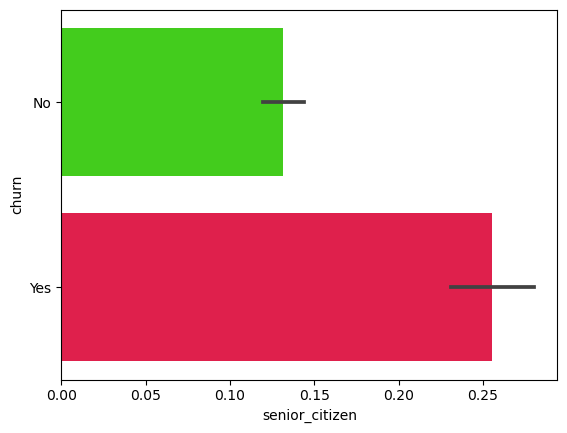

In [9]:
e.barplot_senior_citizen(train)

> As we can see, senior citizens have a higher churn rate than non senior citizens, so lets analyze that.

## Stats test

null and alternative hypothesis

$H_o$ : There is NO relationship between being a senior citizen or not and a customer churning.

$H_a$ : There is a relationship between someone being a senior citzien or not and a customer churning.

In [10]:
# before we start we have to set the confidence level or the alpha
alpha = 0.05

In [11]:
# using a chi2 test since they are catergorical variables
e.chi2_senior_citizen(train)

p-value: 1.5271938515844278e-21
We can reject our null hypothesis and say that there is a relationship between being a senior citizen and churn


### Summarize 

There is a relationship between being a senior citizen and churning.

### Question 2: Is there a relationship between being female and churn?

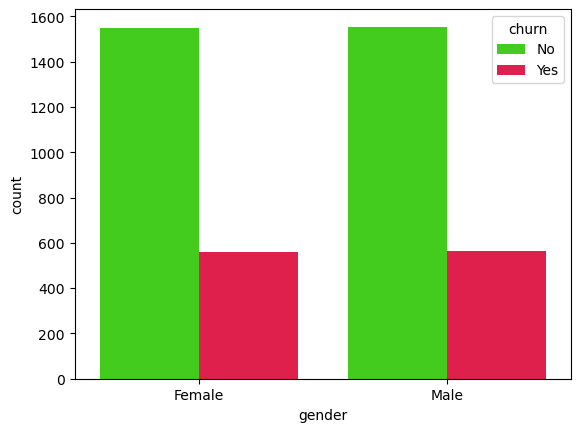

In [12]:
e.countplot_gender(train)

> We can see that both genders are similar when it comes to churning, but lets do a stats test just to make sure.

## Stats test

$H_o$ : There is NO relationship between being female and churn

$H_a$: There is a relationship between being female and churn

In [13]:
# Using the function in my explre.py file
e.chi2_gender(train)

p-value: 0.996031931504371
We fail to reject our null hypothesis and say that there is NO relationship between being a female and churn


### Summarize

There is no relationship between being a female and churn.

## Question 3: Does monthly charges affect churn?

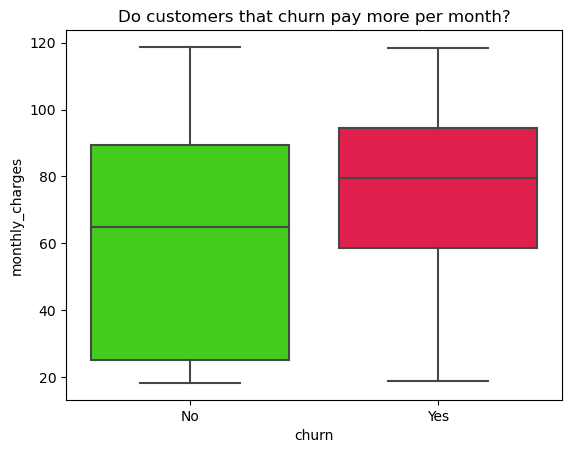

In [14]:
e.boxplot_monthly_charges(train)

> The median monthly charge is higher for customers that churned compared to the customers that have not churned.

## Stats test

$H_o$ : There is NO relationship between monthly charges and churn

$H_a$ : There IS a relationship between monthly charges and churn

In [15]:
e.ttest_monthly_charges(train)

p-value: 5.279235952338065e-34
We reject the null hypothesis


## Summarize

We can conclude that monthly charges does affect churn.

### Question 4: Does having dependents affect churn?

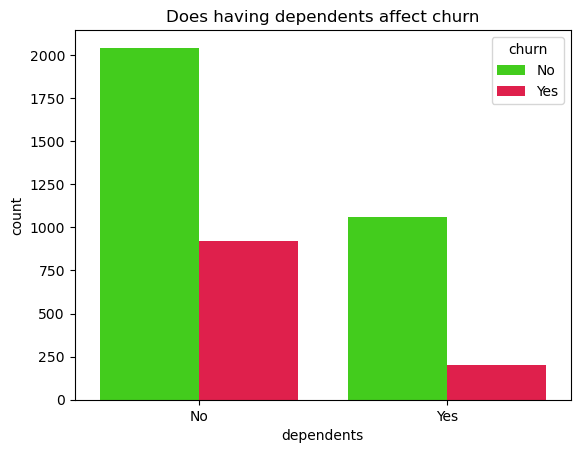

In [16]:
e.countplot_dependents(train)

> Customers with no dependents churn more than customers who do have dependents

## Stats test

My null and alternative hypothesis

$H_o$ : There is NO relationship between having dependents and churn.

$H_a$: There IS a relationship between dependents and churn.

In [17]:
e.chi2_dependents(train)

p-value: 8.298049251133243e-156
We can reject our null hypothesis and say that there is a relationship between dependents and churn


### Modeling

> Lets start by getting the baseline

In [18]:
# Get the baseline
train.churn.value_counts(normalize=True)

churn
No     0.734675
Yes    0.265325
Name: proportion, dtype: float64

> baseline accuracy is 73%

In [19]:
# Time to encode 

train_encoded, validate_encoded, test_encoded = prepare.preprocess_telco(train, validate, test)

In [20]:
# Taking a peek at the new df

train_encoded.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
4083-BFNYK,1,38,95.00,3591.25,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
5804-LEPIM,1,2,70.35,139.05,0,0,0,1,0,0,...,0,1,1,0,0,1,0,0,1,0
4895-TMWIR,1,11,19.95,214.75,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
1342-JPNKI,0,10,86.05,834.10,1,0,0,1,0,1,...,0,1,1,0,0,1,0,0,0,0
3397-AVTKU,0,43,60.00,2548.55,1,0,0,1,0,0,...,1,1,0,0,1,0,0,0,1,0


#### Defining X and y

In [21]:
# Determine X (also means determine the features)

X_train = train_encoded.drop(columns='churn_Yes')
X_validate = validate_encoded.drop(columns='churn_Yes')
X_test = test_encoded.drop(columns='churn_Yes')

In [22]:
# Determine y (also mean determine the target variable)

y_train = train_encoded.churn_Yes
y_validate = validate_encoded.churn_Yes
y_test = test_encoded.churn_Yes

### Let's start with Logistic Regression

In [23]:
# The features that are going to be modeled

features = ['senior_citizen', 'monthly_charges', 'dependents_Yes']
X_train[features].head()

,senior_citizen,monthly_charges,dependents_Yes
customer_id,,,
4083-BFNYK,1,95.00,0
5804-LEPIM,1,70.35,0
4895-TMWIR,1,19.95,0
1342-JPNKI,0,86.05,0
3397-AVTKU,0,60.00,0


In [24]:
# Make and fit the model

logr = LogisticRegression()

logr.fit(X_train[features], y_train)

LogisticRegression()

In [25]:
# Calculate and return the accuracy score of the Logistic Regression 

logr.score(X_train[features], y_train)

0.7256804733727811

> Since the model's accuracy score is close to our baseline, we will not use this model.

### Random Forest

In [26]:
# initializes an empty list named stats. Creates a for-loop that iterates 10 times each time changing max depth and min leaf samples. Then appends to the list and prints out results.
stats = []

for x in range(1,21):
    rf = RandomForestClassifier(min_samples_leaf=x, max_depth=21-x, random_state=123)

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_train)

    acc = rf.score(X_train, y_train)
    acc_val = rf.score(X_validate, y_validate)
    
    stats.append([x,21-x,round(acc,2),round(acc_val,2) ]) 
    
    print(f'min_leaf_samples = {x}, max_depth = {21-x}, accuracy train = {round(acc,3)}, val = {round(acc_val,3)}')

min_leaf_samples = 1, max_depth = 20, accuracy train = 0.998, val = 0.789
min_leaf_samples = 2, max_depth = 19, accuracy train = 0.928, val = 0.801
min_leaf_samples = 3, max_depth = 18, accuracy train = 0.89, val = 0.801
min_leaf_samples = 4, max_depth = 17, accuracy train = 0.868, val = 0.806
min_leaf_samples = 5, max_depth = 16, accuracy train = 0.859, val = 0.808
min_leaf_samples = 6, max_depth = 15, accuracy train = 0.849, val = 0.809
min_leaf_samples = 7, max_depth = 14, accuracy train = 0.843, val = 0.801
min_leaf_samples = 8, max_depth = 13, accuracy train = 0.839, val = 0.801
min_leaf_samples = 9, max_depth = 12, accuracy train = 0.835, val = 0.803
min_leaf_samples = 10, max_depth = 11, accuracy train = 0.83, val = 0.804
min_leaf_samples = 11, max_depth = 10, accuracy train = 0.827, val = 0.804
min_leaf_samples = 12, max_depth = 9, accuracy train = 0.823, val = 0.808
min_leaf_samples = 13, max_depth = 8, accuracy train = 0.817, val = 0.806
min_leaf_samples = 14, max_depth = 7, 

In [27]:
# Creating a new df to get a better look 

stats_df = pd.DataFrame(stats, columns = ['min_leaf', 'max_depth', 'train_acc', 'val_acc'])
stats_df                                       

,min_leaf,max_depth,train_acc,val_acc
0,1,20,1.00,0.79
1,2,19,0.93,0.80
2,3,18,0.89,0.80
3,4,17,0.87,0.81
4,5,16,0.86,0.81
5,6,15,0.85,0.81
6,7,14,0.84,0.80
7,8,13,0.84,0.80
8,9,12,0.83,0.80
9,10,11,0.83,0.80


In [28]:
stats_df.sort_values('val_acc', ascending=False)

,min_leaf,max_depth,train_acc,val_acc
3,4,17,0.87,0.81
4,5,16,0.86,0.81
5,6,15,0.85,0.81
11,12,9,0.82,0.81
12,13,8,0.82,0.81
10,11,10,0.83,0.80
2,3,18,0.89,0.80
6,7,14,0.84,0.80
7,8,13,0.84,0.80
8,9,12,0.83,0.80


> Choosing to go with min_leaf of 6 with a max_depth of 15 to be conservative of not being overfit

### Decision Tree

In [29]:
# creates a for loop iterating 20 times with a different max depth each iteration.
for x in range(1,21):
    #create the decision tree object
    tree = DecisionTreeClassifier(max_depth=x)
    
    #fit the object only on TRAIN DATA!
    tree.fit(X_train, y_train)
    
    #calculate the accuracy for train and validate
    acc = tree.score(X_train, y_train)
    acc_v = tree.score(X_validate, y_validate)
    
    print(f'max depth of {x}, the accuracy train = {round(acc,4)}, val = {round(acc_v,4)}')

max depth of 1, the accuracy train = 0.7359, val = 0.7253
max depth of 2, the accuracy train = 0.7837, val = 0.7878
max depth of 3, the accuracy train = 0.7837, val = 0.7878
max depth of 4, the accuracy train = 0.7927, val = 0.7771
max depth of 5, the accuracy train = 0.8024, val = 0.7921
max depth of 6, the accuracy train = 0.8107, val = 0.7892
max depth of 7, the accuracy train = 0.826, val = 0.7857
max depth of 8, the accuracy train = 0.8402, val = 0.7906
max depth of 9, the accuracy train = 0.8601, val = 0.7821
max depth of 10, the accuracy train = 0.8845, val = 0.7615
max depth of 11, the accuracy train = 0.9041, val = 0.7573
max depth of 12, the accuracy train = 0.9243, val = 0.758
max depth of 13, the accuracy train = 0.9415, val = 0.7566
max depth of 14, the accuracy train = 0.9529, val = 0.7502
max depth of 15, the accuracy train = 0.9645, val = 0.7516
max depth of 16, the accuracy train = 0.9723, val = 0.7367
max depth of 17, the accuracy train = 0.977, val = 0.7424
max depth

> Choosing to go with max depth of 3 to be conservative of not being overfit

### Evaluation

* After checking the accuracies of the the models, Random Forest was the best one

* Random Forest will be used as our final model for the test data evaluation

In [30]:
# creates the random forest object
rf = RandomForestClassifier(min_samples_leaf=6, max_depth=15, random_state=123)

# fits the object only on train data
rf.fit(X_train, y_train)

# saves the predictions of X_test to a variable y_pred
y_pred = rf.predict(X_test)

# calculates the accuracy for test
acc_test = rf.score(X_test, y_test)

print(f'min_leaf_samples = 6, max_depth = 15, accuracy test = {round(acc_test,3)}')

min_leaf_samples = 6, max_depth = 15, accuracy test = 0.803


> The final model's score is 80%, which is higher than the baseline.

### Conclusion

#### Recommendations

> For customers who are have high monthly charges, I would recommened providing targeted retention offers, such as discounts or additional services, to incentivize them to stay.

> For customers who do not have dependents, maybe creating customized offers or promotions that align with the lifestyle of individuals without dependents will encourage them to stay.

> For customers who are senior citizens, Providing personalized and patient customer support that caters to the specific needs of senior citizens could help reduce the churn of customers who are senior citizens.

### Next Steps

* With more time, I could look deeper into monthly charges and check to see what exactly is causing their high charges.

* Come back to the model and update it with any new findings.